# UCLA SWE Reanalysis Data Access

This workbook is to access the Western United States snow reanalysis data set, as developed by UCLA. Normally, the data is provided as PNG or netCDF files, and it is not cloud-optimized. So, we will need to download the data into a `tmp/` folder, as a direct access will be computationally inefficient.

In [ ]:
import xarray as xr
import earthaccess
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

As implied by the dataset's name, the UCLA reanalysis is only for the Western United States. For this example, we will look over the Tuolumne River Basin in California.

As with the MERRA-2 example workbook, we will be using the dataset DOI to quickly access the data, and looking at the 2020-2021 water year.

In [ ]:
# Define bounding box over the Tuolumne
bbox = (-119.85, 37.71, -119.1, 38.25)

# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

# Search for the granule by DOI
results = earthaccess.search_data(
    doi='10.5067/PP7T2GBI52I2',
    temporal=("2020-10-01", "2021-09-30"),
    bounding_box = bbox
)

In [39]:
# Download the files to a tmp folder, and save paths as a list
files = earthaccess.download(results, "/home/jovyan/tmp/")
files

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['/home/jovyan/tmp/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc',
 '/home/jovyan/tmp/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc',
 '/home/jovyan/tmp/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2020_21_SD_POST.nc',
 '/home/jovyan/tmp/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SD_POST.nc']

The four files we downloaded provide reanalysis data for snow water equivalent and snow cover (`SWE_SCA_POST`), as well as snow depth (`SD_POST`). We have two files for each to correspond to different latitudes (`N37` and `N38` in the file names).

We could load these files individually, but Xarray has functionality to load all of them at once with `xarray.open_mfdataset()`!

In [48]:
ds = xr.open_mfdataset(files)

In [49]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (Day: 365, Stats: 5, Longitude: 225, Latitude: 450)
Coordinates:
  * Latitude   (Latitude) float32 2kB 39.0 38.99 38.99 ... 37.01 37.01 37.0
  * Longitude  (Longitude) float32 900B -120.0 -120.0 -120.0 ... -119.0 -119.0
Dimensions without coordinates: Day, Stats
Data variables:
    SWE_Post   (Day, Stats, Longitude, Latitude) float32 739MB dask.array<chunksize=(1, 5, 225, 225), meta=np.ndarray>
    SCA_Post   (Day, Stats, Longitude, Latitude) float32 739MB dask.array<chunksize=(1, 5, 225, 225), meta=np.ndarray>
    SD_Post    (Day, Stats, Longitude, Latitude) float32 739MB dask.array<chunksize=(1, 5, 225, 225), meta=np.ndarray>

Our DataArray has four dimensions: `Day`, `Stats`, `Longitude`, and `Latitude`. `Days` refers to the number of days after the start of the water year (October 1st), which isn't very useful on its own. So, let's change it into a datetime format.

In [55]:
import re
import pandas as pd

# Find year in file name
url = files[0]
date_pattern = r'\d{4}'

# Convert year to start of water year (pd.datetime format)
WY_start_date = pd.to_datetime(f'{re.search(date_pattern, url).group()}-10-01')

In [56]:
# Define new coordinates that use dates rather than day numbers
ds.coords['time'] = ("Day", pd.date_range(WY_start_date, periods=ds.sizes['Day']))
ds = ds.swap_dims({'Day':'time'})

The `Stats` coordinate refers to the statistics that are available for each of the variables, but its inputs are numeric, rather than strings. The `stats_dictionary` below outlines the statistics associated with each number, with `25pct` and `75pct` referring to the 25th-percentile and the 75th-percentile, respectively.

In [58]:
# Make dictionary of statistics
stats_dictionary = {'mean':0, 
                    'std':1, 
                    'median':2, 
                    '25pct':3, 
                    '75pct':4}

# Choose statistic of interest
stat = stats_dictionary['mean']

For this example, we are grabbing the mean daily SWE (`SWE_Post`):

In [59]:
mean_daily_swe = ds['SWE_Post'].sel(Stats=stat)

In [64]:
mean_daily_swe

<xarray.DataArray 'SWE_Post' (time: 365, Longitude: 225, Latitude: 450)> Size: 148MB
dask.array<getitem, shape=(365, 225, 450), dtype=float32, chunksize=(1, 225, 225), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float32 2kB 39.0 38.99 38.99 ... 37.01 37.01 37.0
  * Longitude  (Longitude) float32 900B -120.0 -120.0 -120.0 ... -119.0 -119.0
  * time       (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
Attributes:
    Units:    meters

Looking at the output, we can see that the data now has "Array" and "Chunk" information. This is because the data was lazy-loaded through the dask, given that there is a lot of data stored in each file. 

Before we plot the data, we will need to reduce it to our time frequency of interest (monthly, in this case). We will then properly load the data into memory.

In [61]:
# Resample the SWE data to a monthly mean
mean_monthly_swe = mean_daily_swe.resample(time="1ME").mean()

In [ ]:
# Load the monthly mean data into memory
mean_monthly_swe = mean_monthly_swe.compute()

**Caution**: The above plotting cell can be a bit time-consuming if you are working with a lot of files at once.

Finally, we will make a figure showing the monthly SWE across an entire water year.

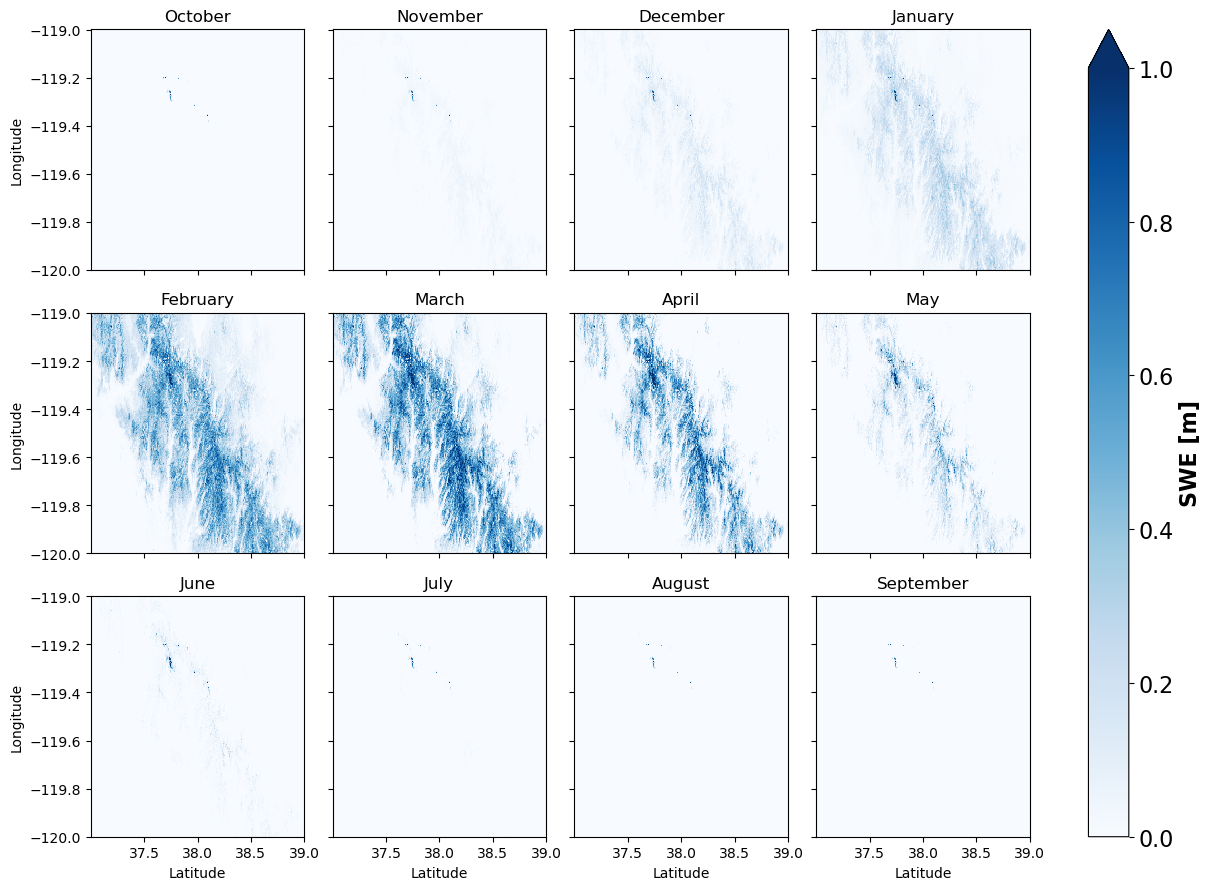

In [69]:
# Define months as strings, for subplot titles
months = ['October', 'November', 'December', 'January',
          'February', 'March', 'April', 'May',
          'June', 'July', 'August', 'September']

# Plot the SWE data as monthly means
fig = mean_monthly_swe.plot.imshow(
    col='time',
    col_wrap=4,
    cmap="Blues",
    vmin=0,
    vmax=1,
)

# Set titles to month
for ax, title in zip(fig.axs.flatten(), months):
    ax.set_title(title, fontsize=12)

# Change colorbar label and label sizes
fig.cbar.ax.tick_params(labelsize=16)
fig.cbar.set_label(label='SWE [m]', size=16, weight='bold')